## <b>  Modeling disaster-related twitter topics using Gensim

### <b> Setup 

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings("ignore")

from src import Cleaning, Visualization

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy


import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

/home/carina/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### <b> Data Loading


In [5]:
twitter_df = pd.read_csv('../datasets/nlp-getting-started/twitter.csv')
twitter_df.sample(5)

,id,keyword,location,text,target
3213,4609,emergency%20services,"CA, AZ & NV",We're #hiring! Read about our latest #job open...,0
2175,3118,debris,NaN,#?? #???? #??? #??? MH370: Aircraft debris fou...,1
3577,5110,famine,Charter Member of the VRWC,Russian 'food crematoria' provoke outrage amid...,1
1866,2682,crush,NaN,Seriously have the biggest girl crush ever on ...,0
6150,8775,siren,"Massachusetts, USA",@EnvySeven My beautiful Aquarius queenmy Siren...,0


In [ ]:
twitter_df = twitter_df[twitter_df['target'] == 1]

### <b>  Data Processing


In [8]:
twitter_df.isna().sum()

id             0
keyword       42
location    1075
text           0
target         0
dtype: int64

In [9]:
'''
    Remove location column and empty keywords rows
'''
twitter_df = twitter_df[['keyword', 'text', 'target']] 
twitter_df.dropna(axis=0, how='any', inplace=True)

In [10]:
twitter_df.sample(10)

,keyword,text,target
1427,casualty,Train derailment: In Patna no news of any casu...,1
78,accident,I-77 Mile Marker 31 to 40 South Mooresville I...,1
4893,massacre,Petition/No Medals for 1890 Massacre Justice f...,1
5637,refugees,@fadelurker @dalinthanelan &lt; right now.\n\n...,1
4917,mayhem,I liked a @YouTube video from @itsjustinstuart...,1
1774,collision,Motorcyclist bicyclist injured in Denver colli...,1
6604,terrorism,Cross-border terrorism: Pakistan caught red-ha...,1
1090,bomb,The Guardian view on the Hiroshima legacy: sti...,1
87,accident,RT nAAYf: First accident in years. Turning ont...,1
6449,suicide%20bombing,'Suicide bombing at [location named]...' #prem...,1


In [12]:
'''
    Clean text from text and keyword columns
'''
clean_text = Cleaning.DataCleaning()
twitter_df.loc[:, 'clean_keyword'] = twitter_df['keyword'].apply(lambda x: " ".join(clean_text(x)))
twitter_df.loc[:, 'clean_text'] = twitter_df['text'].apply(lambda x: " ".join(clean_text(x)))

In [13]:
twitter_df[['text', 'clean_text']].sample(10)

,text,clean_text
1761,Motorcyclist bicyclist injured in Denver colli...,motorcyclist bicyclist injured denver collisio...
3782,SIGALERT UPDATE #3***N-133 CLOSED AT 5 FWY UFN...,sigalert update closed fwy ufn trash truck fire
7301,Firefighters Headed To California To Fight Wil...,firefighter headed california fight wild fire ...
1103,On 1st August #Turkish jets bombed the village...,august turkish jet bombed village zergele qend...
625,CDC has a pretty cool list of all bioterrorism...,cdc pretty cool list bioterrorism agent
6681,@OriginalFunko @Spencers THUNDER BUDDYS!!!! TH...,originalfunko spencer thunder buddy thunder buddy
2680,#hiphop #news #indie Apollo Brown ÛÒ ÛÏDeton...,hiphop news indie apollo brown lt http
5107,The president spoke of Kennedy's diplomacy to ...,president spoke kennedy diplomacy avert nuclea...
3928,iembot_hfo : At 10:00 AM 2 NNW Hana [Maui Co H...,nnw hana maui co hi county official report coa...
3477,GAElite 0 Explosion Greg 2 [Top 3rd] [0 Out...,gaelite explosion greg top ball strike one p m...


In [14]:
'''
    Inspect empty columns after cleaning
'''
twitter_df = twitter_df[~twitter_df['clean_text'].isna()]
twitter_df = twitter_df[twitter_df['clean_text'] != '']

twitter_df = twitter_df[~twitter_df['clean_keyword'].isna()]
twitter_df = twitter_df[twitter_df['clean_keyword'] != '']

In [15]:
'''
   Counting words
'''
twitter_df.loc[:, 'word_count'] = twitter_df['clean_text'].apply(lambda x: len(x.split()))

### <b> Data Visualization

In [28]:
data_viz = Visualization.Visualization(twitter_df, 'clean_text')
frequency = data_viz.words_frequency()

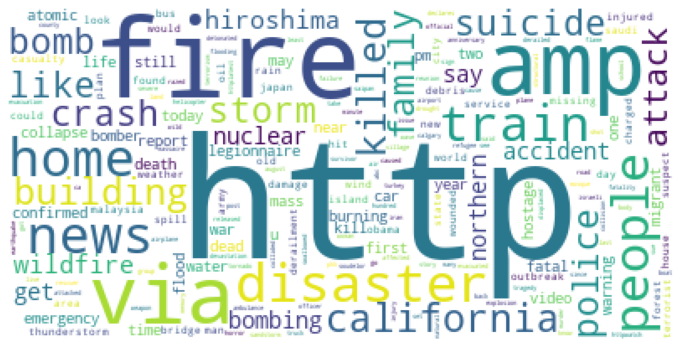

In [29]:
data_viz.word_cloud()

### <b>  Tokenize Sentence


In [30]:
sentences = list([row.split(' ') for row in twitter_df['clean_text']])

In [31]:
sentences[:1]

[['bbcmtd', 'wholesale', 'market', 'ablaze', 'http']]

### <b>  Ngram Models


In [32]:
bigram = gensim.models.Phrases(sentences, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
bigrams = [bigram_mod[row] for row in sentences]

### <b>  Create the Dictionary and Corpus


In [33]:
id2word = corpora.Dictionary(bigrams)

In [34]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in bigrams]

In [35]:
# mapping of (word_id, word_frequency).
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


In [36]:
sentences[0]

['bbcmtd', 'wholesale', 'market', 'ablaze', 'http']

In [37]:
id2word[2]

'http'

In [38]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ablaze', 1), ('bbcmtd', 1), ('http', 1), ('market', 1), ('wholesale', 1)]]

### <b>  Topic Model



In [40]:
# Build LDA model
num_topics = 6
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### <b> View Topics



In [41]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics()[0])
doc_lda = lda_model[corpus]

(0,
 '0.022*"storm" + 0.016*"say" + 0.015*"flight" + 0.014*"terrorist" + '
 '0.014*"nuclear" + 0.013*"home" + 0.013*"violent" + 0.013*"like" + '
 '0.012*"shot" + 0.012*"warning"')


Topic 0 is a represented as:
> (0,
 '0.022*"storm" + 0.016*"say" + 0.015*"flight" + 0.014*"terrorist" + '
 '0.014*"nuclear" + 0.013*"home" + 0.013*"violent" + 0.013*"like" + '
 '0.012*"shot" + 0.012*"warning"')

It means the top 10 keywords that contribute to this topic are: ‘storm’, ‘say’, ‘flight’.. and so on and the weight of ‘storm’ on topic 0 is 0.022.

**The weights reflect how important a keyword is to that topic.**

### <b> Compute Model Perplexity and Coherence Score



Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. 

In [42]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -9.016591175469724


In [43]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5855680310964432


### <b> Visualize the topics-keywords



In [44]:
# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)

### <b> Visualize Dominant topic



In [45]:
# Init output
sent_topics_df = pd.DataFrame()

# Get main topic in each document
for i, row_list in enumerate(lda_model[corpus]):
    row = row_list[0] if lda_model.per_word_topics else row_list 
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
sent_topics_df.columns = ['Dominant Topic', 'Percentual of Contribution', 'Topic Keywords']


In [46]:
sent_topics_df.head()

,Dominant Topic,Percentual of Contribution,Topic Keywords
0,3.0,0.3840,"http, wreckage_confirmed, malaysia_pm, investi..."
1,3.0,0.3474,"http, wreckage_confirmed, malaysia_pm, investi..."
2,3.0,0.6025,"http, wreckage_confirmed, malaysia_pm, investi..."
3,3.0,0.6743,"http, wreckage_confirmed, malaysia_pm, investi..."
4,1.0,0.3637,"wildfire, california, u, earthquake, released,..."


In [47]:
# Add original text to the end of the output
contents = pd.Series(twitter_df['clean_text'])
sent_topics_df.loc[:, 'Tweet'] = contents

In [48]:
sent_topics_df[sent_topics_df['Dominant Topic'] == 1].sample(1)

,Dominant Topic,Percentual of Contribution,Topic Keywords,Tweet
33,1.0,0.4469,"wildfire, california, u, earthquake, released,...",africanbaze breaking news nigeria flag set abl...


In [50]:
sent_topics_df.loc[33, 'Tweet']

'africanbaze breaking news nigeria flag set ablaze aba http'

In [51]:
sent_topics_df = sent_topics_df[~sent_topics_df['Tweet'].isna()]

### <b> Words Frequency



In [52]:
doc_lens = [len(d) for d in sent_topics_df['Tweet']]

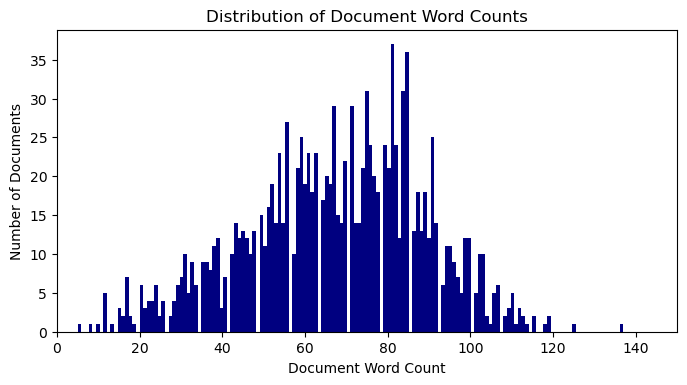

In [53]:
# Plot
plt.figure(figsize=(8,4), dpi=100)
ax = plt.hist(doc_lens, bins = 150, color='navy')
ax = plt.gca().set(xlim=(0, 150), ylabel='Number of Documents', xlabel='Document Word Count')
ax = plt.title('Distribution of Document Word Counts', fontdict=dict(size=12))
ax = plt.show()

### <b> Words Frequency (three topics with more words)



In [64]:
topics_dict = {}
list_of_topics = []
for topic in range(num_topics):
    df_dominant_topic_sub = sent_topics_df.loc[sent_topics_df['Dominant Topic'] == topic, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub['Tweet']]
    if len(doc_lens) > 50 and  len(doc_lens) < 2000:
        topics_dict[topic] = doc_lens
        list_of_topics.append(topic)

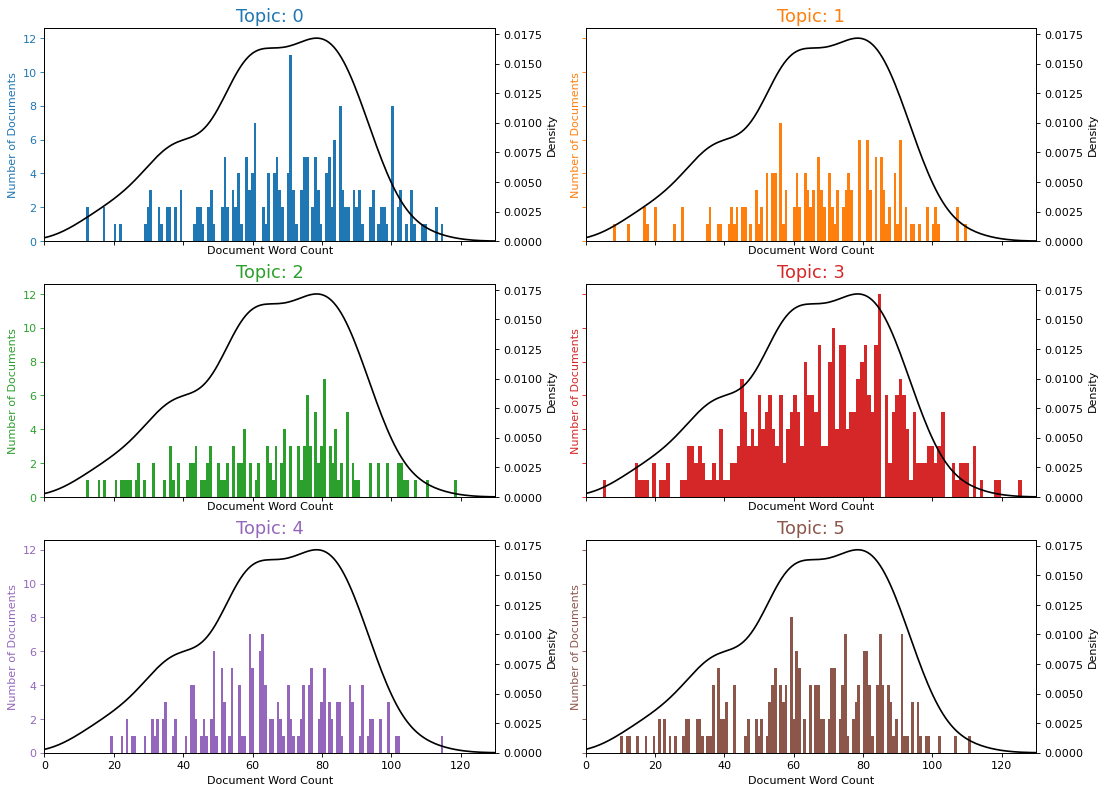

In [69]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
fig, axes = plt.subplots(3,2,figsize=(16,12), dpi=80, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    doc_len = topics_dict[list_of_topics[i]]
    ax.hist(doc_len, bins = 130, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 130), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(list_of_topics[i]), fontdict=dict(size=16, color=cols[i]))

### <b> Word Clouds of Top N Keywords in Each Topic




In [70]:
from wordcloud import WordCloud

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

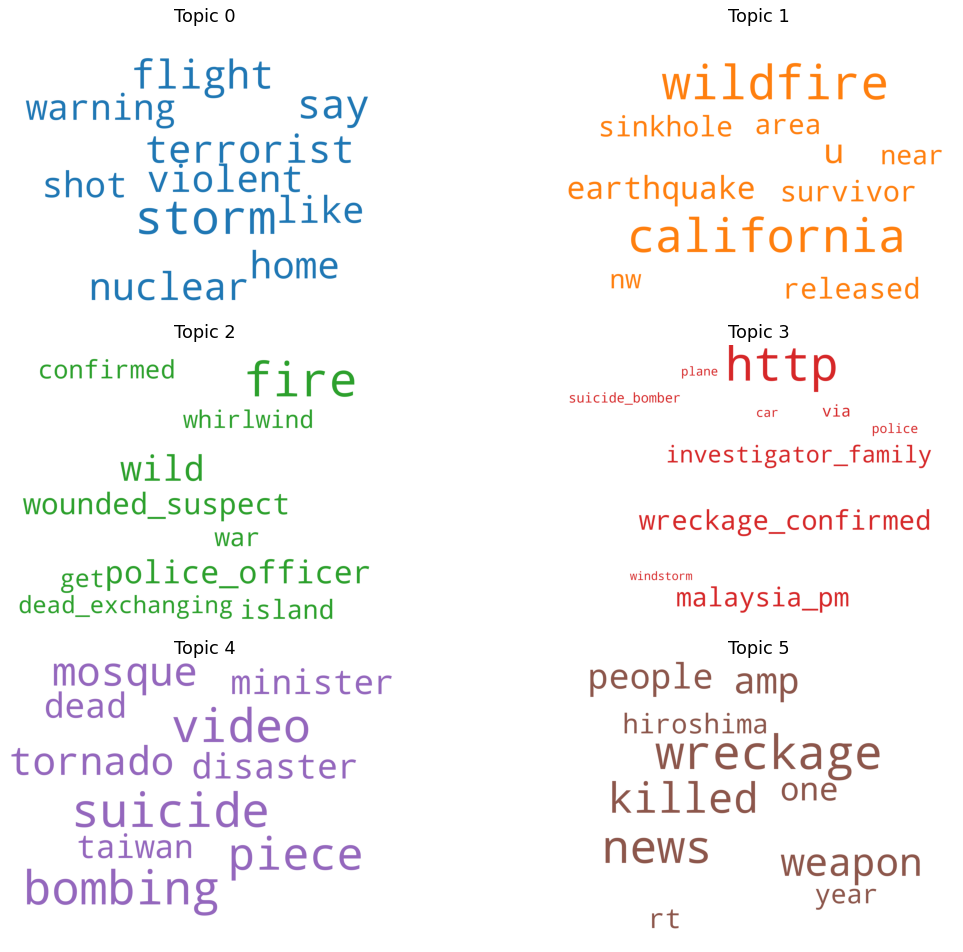

In [71]:
fig, axes = plt.subplots(3,2,figsize=(16,12), dpi=80, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):  
    fig.add_subplot(ax)
    topic = list_of_topics[i]    
    topic_words = dict(lda_model.show_topic(topic))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(list_of_topics[i]), fontdict=dict(size=16))
    plt.gca().axis('off') 
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()    

### <b>t-SNE



In [72]:
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])
        
arr = pd.DataFrame(topic_weights).fillna(0).values    
arr = arr[np.amax(arr, axis=1) > 0.35]

In [73]:
topic_num = np.argmax(arr, axis=1)

In [74]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2459 samples in 0.001s...
[t-SNE] Computed neighbors for 2459 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2459
[t-SNE] Computed conditional probabilities for sample 2000 / 2459
[t-SNE] Computed conditional probabilities for sample 2459 / 2459
[t-SNE] Mean sigma: 0.000112
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.635109
[t-SNE] KL divergence after 1000 iterations: 0.727314


In [75]:
mycolors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
       '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#17btcf','#d62743', '#8dt64b',
          '#2f77b4', '#2ca02e', '#df7f0e' ])

In [76]:
# Plot the Topic Clusters using Bokeh
output_notebook()


plot = figure(title="t-SNE Clustering of {} LDA Topics".format(num_topics), 
              plot_width=900, plot_height=700)

plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

Loading BokehJS ...

**References:**

> [Reference 1](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)
> 
> [Reference 2](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
> 
> [Reference 3](https://radimrehurek.com/gensim/)